In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils.parametrizations import spectral_norm

from torchvision import datasets, transforms, utils
import seaborn as sns
import matplotlib.pyplot as plt
from torchsummary import summary
from dataTransformation import labels4clients, distribute_data_labels4clients
from gan_model import Discriminator, Generator, initialize_weights
from network import Server, Worker
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader
from utils import Logger

In [2]:
LEARNING_RATE = 2e-4  # could also use two lrs, one for gen and one for disc
BATCH_SIZE = 64
NOISE_DIM = 128
NUM_EPOCHS = 50

In [3]:
num_workers = 1
num_unique_users = num_workers
num_classes = 10
classes_per_user = 10

logger = Logger(model_name='F2U',data_name='CIFAR10')
dictionary = labels4clients(num_classes,classes_per_user,num_workers,num_unique_users,False)
print(dictionary)

{0: [0], 1: [0], 2: [0], 3: [0], 4: [0], 5: [0], 6: [0], 7: [0], 8: [0], 9: [0]}


In [4]:
trans_cifar = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = datasets.CIFAR10(root='./datasets/cifar/', train=True, download=True, transform=trans_cifar)
dataset_test = datasets.CIFAR10(root='./datasets/cifar/', train=False, download=True, transform=trans_cifar)
dataloader_one = torch.utils.data.DataLoader(dataset, shuffle = True,batch_size=BATCH_SIZE) 

Files already downloaded and verified
Files already downloaded and verified


In [5]:
print(dataset.data[0])
print(dataset.transforms(dataset.data[0],transforms.ToTensor()))
print(dataset.transforms(dataset.data[0],trans_cifar))

[[[ 59  62  63]
  [ 43  46  45]
  [ 50  48  43]
  ...
  [158 132 108]
  [152 125 102]
  [148 124 103]]

 [[ 16  20  20]
  [  0   0   0]
  [ 18   8   0]
  ...
  [123  88  55]
  [119  83  50]
  [122  87  57]]

 [[ 25  24  21]
  [ 16   7   0]
  [ 49  27   8]
  ...
  [118  84  50]
  [120  84  50]
  [109  73  42]]

 ...

 [[208 170  96]
  [201 153  34]
  [198 161  26]
  ...
  [160 133  70]
  [ 56  31   7]
  [ 53  34  20]]

 [[180 139  96]
  [173 123  42]
  [186 144  30]
  ...
  [184 148  94]
  [ 97  62  34]
  [ 83  53  34]]

 [[177 144 116]
  [168 129  94]
  [179 142  87]
  ...
  [216 184 140]
  [151 118  84]
  [123  92  72]]]
(tensor([[[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
         [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
         [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
         ...,
         [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
         [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],


In [6]:
normalized = transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
print(normalized)
trans_cifar(dataset.data[0])

Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))


tensor([[[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
         [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
         [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
         ...,
         [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
         [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],
         [ 0.3882,  0.3176,  0.4039,  ...,  0.6941,  0.1843, -0.0353]],

        [[-0.5137, -0.6392, -0.6235,  ...,  0.0353, -0.0196, -0.0275],
         [-0.8431, -1.0000, -0.9373,  ..., -0.3098, -0.3490, -0.3176],
         [-0.8118, -0.9451, -0.7882,  ..., -0.3412, -0.3412, -0.4275],
         ...,
         [ 0.3333,  0.2000,  0.2627,  ...,  0.0431, -0.7569, -0.7333],
         [ 0.0902, -0.0353,  0.1294,  ...,  0.1608, -0.5137, -0.5843],
         [ 0.1294,  0.0118,  0.1137,  ...,  0.4431, -0.0745, -0.2784]],

        [[-0.5059, -0.6471, -0.6627,  ..., -0.1529, -0.2000, -0.1922],
         [-0.8431, -1.0000, -1.0000,  ..., -0

In [7]:
# print(dataset.data.shape)
# print(type(dataset))
# print(dataloader_one.dataset.data.shape)
# x,_ = dataloader_one.dataset[0]
# print(x.shape)
# print(x)

In [8]:
x_train_normalized_np = np.empty((dataset.data.shape[0],dataset.data.shape[3],dataset.data.shape[1],dataset.data.shape[2]))
for i in range(len(dataset)):
    x_train_normalized_np[i] = trans_cifar(dataset.data[i])

In [9]:
x_train = np.asarray(dataset.data)
y_train = np.asarray(dataset.targets)
x_clinet_list, y_client_list = distribute_data_labels4clients(x_train_normalized_np,y_train,dictionary,False)

In [10]:
def getDist(y,num_classes,user_num):
    ax = sns.countplot(x=y)
    ax.set(title="Count of data classes for %s" %user_num)
    plt.show()

50000


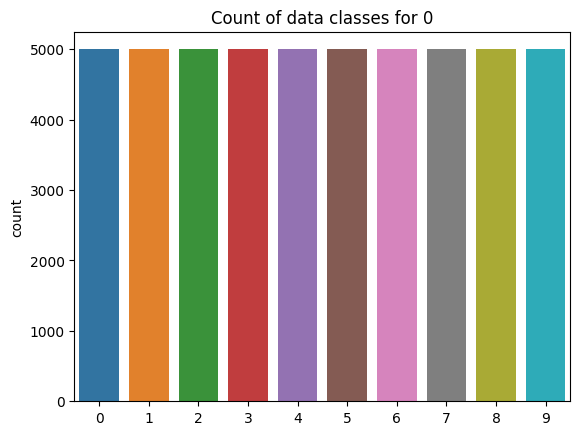

In [11]:
for i in range (len(x_clinet_list)):
    print(len(y_client_list[i]))
    getDist(y_client_list[i],num_classes,i)

In [12]:
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
dev = torch.device(dev)

In [13]:
# netG = Generator().to(dev)
# netD = Discriminator().to(dev)
# summary(netG,(128,1,1))
# summary(netD,(3,32,32))

In [14]:
main_server = Server(0,LEARNING_RATE)
main_server.generator.train()
workers = []
for i in range(num_workers):
    worker = Worker(i,LEARNING_RATE)
    # x_clinet_list[i] = np.transpose(x_clinet_list[i],(0, 3, 1, 2))
    worker.load_worker_data(x_clinet_list[i], y_client_list[i])
    worker.discriminator.train()
    workers.append(worker)
    
# summary(main_server.generator,(128,1,1))
# summary(workers[0].discriminator,(3,32,32))

In [15]:
criterion = nn.MSELoss()
fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(dev)

worker_loaders = []

for worker in workers:
    # print(worker.x_data.shape)
    worker_loaders.append([])
    for batch_id, real in enumerate(DataLoader(dataset=worker.x_data,batch_size=BATCH_SIZE)):
        worker_loaders[-1].append(real)

In [16]:
# GAN archicture trial
for epoch in range(NUM_EPOCHS):
    for i, data in enumerate(dataloader_one):
        worker = workers[0]
        noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1,1).to(dev)
        fake = main_server.generator(noise)
        real, _ = data

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        current_disc_real = worker.discriminator(real).reshape(-1)
        worker.loss_disc_real = criterion(current_disc_real, torch.ones_like(current_disc_real))
        current_disc_fake = worker.discriminator(fake.detach()).reshape(-1)
        worker.loss_disc_fake = criterion(current_disc_fake, torch.zeros_like(current_disc_fake))
        worker.loss_disc = (worker.loss_disc_real + worker.loss_disc_fake) / 2
        worker.discriminator.zero_grad()
        worker.loss_disc.backward()
        worker.d_optimizer.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = worker.discriminator(fake).reshape(-1)
        main_server.loss_gen = criterion(output, torch.ones_like(output))
        main_server.generator.zero_grad()
        main_server.loss_gen.backward()
        main_server.g_optimizer.step()

        logger.log(worker.loss_disc.item(),main_server.loss_gen.item(),worker.loss_disc_real, worker.loss_disc_fake,epoch,i,len(dataloader_one))

        # Print losses occasionally and print to tensorboard
        if i % 100 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {i}/{len(dataloader_one)} \
                 Loss D: {worker.loss_disc:.4f}, loss G: {main_server.loss_gen:.4f}"
            )
        if i% 500 == 0:
            with torch.no_grad():
                fake = main_server.generator(fixed_noise)
                logger.log_images(fake,BATCH_SIZE, epoch, i, len(dataloader_one))


Epoch [0/50] Batch 0/782                  Loss D: 0.5007, loss G: 0.7759
Epoch [0/50] Batch 100/782                  Loss D: 0.0379, loss G: 1.1310
Epoch [0/50] Batch 200/782                  Loss D: 0.1520, loss G: 0.9542
Epoch [0/50] Batch 300/782                  Loss D: 0.0328, loss G: 1.0187
Epoch [0/50] Batch 400/782                  Loss D: 0.0272, loss G: 0.9776
Epoch [0/50] Batch 500/782                  Loss D: 0.3674, loss G: 1.0421
Epoch [0/50] Batch 600/782                  Loss D: 0.0201, loss G: 0.9809
Epoch [0/50] Batch 700/782                  Loss D: 0.0516, loss G: 1.0096
Epoch [1/50] Batch 0/782                  Loss D: 0.0920, loss G: 0.7543
Epoch [1/50] Batch 100/782                  Loss D: 0.0884, loss G: 0.8475
Epoch [1/50] Batch 200/782                  Loss D: 0.0729, loss G: 1.0511
Epoch [1/50] Batch 300/782                  Loss D: 0.0595, loss G: 0.9736
Epoch [1/50] Batch 400/782                  Loss D: 0.0599, loss G: 0.9672
Epoch [1/50] Batch 500/782   

In [17]:
# main training loop for F2U
for epoch in range(NUM_EPOCHS):
    for batch_id in range(len(worker_loaders[0])):

        highest_loss = 0
        chosen_discriminator = None
        noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1,1).to(dev)
        fake = main_server.generator(noise)

        for worker_id, worker in enumerate(workers):
            current_worker_real = worker_loaders[worker_id][batch_id].float().to(dev)
            # print(real.shape)

            ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
            current_disc_real = worker.discriminator(current_worker_real).reshape(-1)
            worker.loss_disc_real = criterion(current_disc_real, torch.ones_like(current_disc_real))
            current_disc_fake = worker.discriminator(fake.detach()).reshape(-1)
            worker.loss_disc_fake = criterion(current_disc_fake, torch.zeros_like(current_disc_fake))
            worker.loss_disc = (worker.loss_disc_real + worker.loss_disc_fake) / 2
            worker.discriminator.zero_grad()
            worker.loss_disc.backward()
            worker.d_optimizer.step()
            # print(worker.loss_disc_fake, i)
            if highest_loss < worker.loss_disc_fake:
                highest_loss = worker.loss_disc_fake
                chosen_discriminator = worker_id
        # print(f"chosen worker is {chosen_discriminator} with loss of: {highest_loss.item():.4f}")
        chosen_worker = workers[chosen_discriminator]
        

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = chosen_worker.discriminator(fake).reshape(-1)
        main_server.loss_gen = criterion(output, torch.ones_like(output))
        main_server.generator.zero_grad()
        main_server.loss_gen.backward()
        main_server.g_optimizer.step()

        logger.log(chosen_worker.loss_disc.item(),main_server.loss_gen.item(),chosen_worker.loss_disc_real, chosen_worker.loss_disc_fake,epoch,i,len(worker_loaders[0]))

        # Print losses occasionally and print to tensorboard
        if batch_id % 100 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_id}/{len(worker_loaders[0])} \
                 Loss D: {worker.loss_disc:.4f}, loss G: {main_server.loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = main_server.generator(noise)
                logger.log_images(fake,BATCH_SIZE, epoch, i, len(dataloader_one))


Epoch [0/50] Batch 0/782                  Loss D: 0.1942, loss G: 0.4418
Epoch [0/50] Batch 100/782                  Loss D: 0.1971, loss G: 0.4455
Epoch [0/50] Batch 200/782                  Loss D: 0.1793, loss G: 0.3768
Epoch [0/50] Batch 300/782                  Loss D: 0.1976, loss G: 0.5090


KeyboardInterrupt: 

In [ ]:
# dataloaders = []

# for worker in workers:
#     # print(worker.x_data.shape)
#     dataloaders.append(DataLoader(dataset=worker.x_data,batch_size=BATCH_SIZE))

# i = iter(dataloaders[0])
# print(next(i))

In [ ]:
# criterion = nn.MSELoss()
# NOISE_DIM = 128
# fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(dev)
# writer_real = SummaryWriter(f"logs/real")
# writer_fake = SummaryWriter(f"logs/fake")
# step = 0

# for epoch in range(NUM_EPOCHS):
#     highest_loss = 0
#     chosen_discriminator = None
#     for i, worker in enumerate(workers):
#         print(worker.x_data.shape)
#         dataloader = DataLoader(dataset=worker.x_data,batch_size=BATCH_SIZE)
#         for batch_id, real in enumerate(dataloader):
#             real = real.float().to(dev)
#             # print(real.shape)
#             # print(real)
#             noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1,1).to(dev)
#             fake = main_server.generator(noise)

#             ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
#             disc_real = worker.discriminator(real).reshape(-1)
#             worker.loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
#             disc_fake = worker.discriminator(fake.detach()).reshape(-1)
#             worker.loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
#             loss_disc = (worker.loss_disc_real + worker.loss_disc_fake) / 2
#             worker.discriminator.zero_grad()
#             loss_disc.backward()
#             worker.d_optimizer.step()
#             if batch_id % 20 == 0:
#                 print(
#                     f"Worker: {i} Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_id}/{len(dataloader)} \
#                         Loss D: {loss_disc:.4f}"
#                 )
#         # print(worker.loss_disc_fake, i)
#         if highest_loss < worker.loss_disc_fake:
#             highest_loss = worker.loss_disc_fake
#             chosen_discriminator = i
#         print(f"chosen worker is {chosen_discriminator} with loss of: {highest_loss.item()}")
#     dataloader = DataLoader(dataset=workers[chosen_discriminator].x_data,batch_size=BATCH_SIZE)
        
        


In [ ]:
    ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
    # output = disc(fake).reshape(-1)
    # loss_gen = criterion(output, torch.ones_like(output))
    # gen.zero_grad()
    # loss_gen.backward()
    # opt_gen.step()

    # for batch_idx, (real, _) in enumerate(dataloader):
    #     real = real.to(device)
    #     noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
    #     fake = gen(noise)

    #     ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
    #     disc_real = disc(real).reshape(-1)
    #     loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
    #     disc_fake = disc(fake.detach()).reshape(-1)
    #     loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
    #     loss_disc = (loss_disc_real + loss_disc_fake) / 2
    #     disc.zero_grad()
    #     loss_disc.backward()
    #     opt_disc.step()

    #     ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
    #     output = disc(fake).reshape(-1)
    #     loss_gen = criterion(output, torch.ones_like(output))
    #     gen.zero_grad()
    #     loss_gen.backward()
    #     opt_gen.step()

    #     # Print losses occasionally and print to tensorboard
    #     if batch_idx % 100 == 0:
    #         print(
    #             f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
    #               Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
    #         )

    #         with torch.no_grad():
    #             fake = gen(fixed_noise)
    #             # take out (up to) 32 examples
    #             img_grid_real = torchvision.utils.make_grid(
    #                 real[:32], normalize=True
    #             )
    #             img_grid_fake = torchvision.utils.make_grid(
    #                 fake[:32], normalize=True
    #             )

    #             writer_real.add_image("Real", img_grid_real, global_step=step)
    #             writer_fake.add_image("Fake", img_grid_fake, global_step=step)

    #         step += 1